# Deep Learning - Project

In [20]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import librosa.util
import IPython.display as ipd
import soundfile as sf
import torch
from torchaudio.transforms import MFCC
from IPython.display import Audio

## Load Data

In [5]:
current_dir = os.getcwd()

print("Contents of the current directory:")
for item in os.listdir(current_dir):
    print(item)

Contents of the current directory:
.git
data_subsample
project.ipynb
README.md


In [6]:
data_dir = "data_subsample/"
languages = ["dutch", "english", "chinese", "italian"]

In [7]:
# Loop through languages
for language in languages:
    # language path
    language_path = os.path.join(data_dir, language)
    print("Language path:", language_path) 

    # Check if language path exists
    if os.path.isdir(language_path):
        # Get all directories inside the language folder
        subdirectories = [d for d in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, d))]

        # Check if there are any subdirectories
        if subdirectories:
            # Print subdirectories
            print("Subdirectories:", subdirectories)
        else:
            print(f"No subdirectories found for {language}")

        # clips path
        clips_path = os.path.join(language_path, "clips")

        # Check if clips path exists
        if os.path.isdir(clips_path):
            # Count the number of files in the clips folder
            num_files = len(os.listdir(clips_path))
            print(f"Number of files in {language} clips folder:", num_files)
        else:
            print(f"No clips folder found for {language}")

        print(f"\n")
    else:
        print(f"No directory found for {language}")


Language path: data_subsample/dutch
Subdirectories: ['clips']
Number of files in dutch clips folder: 10


Language path: data_subsample/english
Subdirectories: ['clips']
Number of files in english clips folder: 10


Language path: data_subsample/chinese
Subdirectories: ['clips']
Number of files in chinese clips folder: 10


Language path: data_subsample/italian
Subdirectories: ['clips']
Number of files in italian clips folder: 10




In [8]:
def calculate_audio_length(audio_path):
    # Load audio file using librosa
    y, sr = librosa.load(audio_path, sr=None)
    # Compute duration of audio file in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    return duration

def calculate_average_length(language_folder, max_instances=None):
    total_duration = 0.0
    total_files = 0
    instances_processed = 0

    language_path = os.path.join(data_dir, language_folder)

    # Check if it's a directory
    if os.path.isdir(language_path):
        # Iterate over clips folders
        for clips_folder in os.listdir(language_path):
            clips_path = os.path.join(language_path, clips_folder)

            # Check if it's a directory
            if os.path.isdir(clips_path):
                # Iterate over audio clips
                for audio_file in os.listdir(clips_path):
                    audio_path = os.path.join(clips_path, audio_file)
                    try:
                        # Calculate duration of audio file
                        duration = calculate_audio_length(audio_path)
                        total_duration += duration
                        total_files += 1
                        instances_processed += 1

                        if max_instances and instances_processed >= max_instances:
                            break  # Stop processing instances if limit reached
                    except Exception as e:
                        print(f"Error processing audio file {audio_file}: {e}")

    if total_files > 0:
        average_length = total_duration / total_files
        print(f"Average audio length for language {language_folder}: {average_length:.2f} seconds")
    else:
        print(f"No audio files found for language {language_folder}")

In [9]:
# Dictionary to store average audio lengths for each language
avg_lengths = {}

for language in languages:
    # Calculate average audio length
    avg_length=calculate_average_length(language, max_instances=10)
    avg_lengths[language] = avg_length

Average audio length for language dutch: 4.17 seconds
Average audio length for language english: 5.28 seconds
Average audio length for language chinese: 6.62 seconds
Average audio length for language italian: 6.34 seconds


In [10]:
def get_sampling_rate(language_folder, data_dir, max_instances=None, max_length=None):
    """
    Get the sampling rate from audio files within the clips directory of the specified language.

    Args:
    - language_folder (str): Name of the language folder.
    - data_dir (str): Path to the data directory containing language folders.
    - max_instances (int, optional): Maximum number of instances to read.
    - max_length (int, optional): Maximum length of audio files.

    Returns:
    - sampling_rate (int or None): Sampling rate of the audio files, or None if no audio files found.
    """
    # Construct the path to the clips directory for the specified language
    language_path = os.path.join(data_dir, language_folder, "clips")

    # Initialize an empty list to store sampling rates
    sampling_rates = []

    # Check if the clips directory exists
    if os.path.isdir(language_path):
        # Iterate over audio files in the directory
        for root, dirs, files in os.walk(language_path):
            for file in files:
                # Check if the file is an audio file (you can modify this condition if needed)
                if file.endswith(('.wav', '.mp3', '.flac')):
                    # Construct the full path to the audio file
                    file_path = os.path.join(root, file)
                    try:
                        # Open the audio file and read the sampling rate
                        with sf.SoundFile(file_path) as f:
                            sampling_rate = f.samplerate
                            # Append the sampling rate to the list
                            sampling_rates.append(sampling_rate)

                        # Check if maximum instances limit reached
                        if max_instances and len(sampling_rates) >= max_instances:
                            break
                    except Exception as e:
                        print(f"Error reading sampling rate from {file}: {e}")

        # If there are no audio files, return None
        if not sampling_rates:
            return None

        # Calculate the most common sampling rate
        sampling_rate = max(set(sampling_rates), key=sampling_rates.count)
        return sampling_rate
    else:
        print(f"No clips directory found for language {language_folder}")
        return None

In [11]:
for language in languages:
    sampling_rate = get_sampling_rate(language, data_dir)
    print(f"Sampling rate for {language} language: {sampling_rate}")

Sampling rate for dutch language: 48000
Sampling rate for english language: 32000
Sampling rate for chinese language: 48000
Sampling rate for italian language: 48000


In [12]:
def load_audio_data(language_folder, max_instances=None, max_length=None):
    data = []
    labels = []

    language_path = os.path.join(data_dir, language_folder)

    # Check if it's a directory
    if os.path.isdir(language_path):
        # Iterate over clips folders
        for clips_folder in os.listdir(language_path):
            clips_path = os.path.join(language_path, clips_folder)

            # Check if it's a directory
            if os.path.isdir(clips_path):
                # Iterate over audio clips
                for idx, audio_file in enumerate(os.listdir(clips_path)):
                    if max_instances and idx >= max_instances:
                        break  # Stop reading instances if limit reached

                    audio_path = os.path.join(clips_path, audio_file)
                    try:
                        # Load audio file using librosa
                        y, sr = librosa.load(audio_path, sr=None)

                        # Optionally, pad or truncate the waveform array
                        if max_length:
                            y = librosa.util.fix_length(y, size=max_length)

                        # Append audio data and label to the lists
                        data.append(y)
                        labels.append(language_folder)
                    except Exception as e:
                        print(f"Error loading audio file {audio_file}: {e}")
            else:
                print(f"No clips directory found in {language_folder}")

    return np.array(data), np.array(labels)

In [13]:
MAX_INSTANCES = 10  # max number of instances to read
MAX_LENGTH = 48000 * 60 * 3  # 3 minutes of audio (first term is the assumed sampling rate, in Hz)

"""""
 The MAX_LENGTH parameter should be determined in relation to the sampling rate, 
 as it represents the maximum length of audio data in terms of samples.
"""""

X_all = []
y_all = []

for language in languages:

    # Load audio data for the current language using the language-specific sampling rate
    X_lang, y_lang = load_audio_data(language, max_instances=MAX_INSTANCES, max_length=MAX_LENGTH)

    # Append the instances for the current language to the overall arrays
    X_all.extend(X_lang)
    y_all.extend(y_lang)

# Convert lists to numpy arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

In [14]:
# check
print("First few elements of X_all:", X_all[:5])
print("First few elements of y_all:", y_all[:5])

First few elements of X_all: [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.9317881e-13 -2.3716462e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  2.2192339e-13  6.1491759e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  8.9882339e-13  5.1886121e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  4.0506601e-13  1.6780782e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
First few elements of y_all: ['dutch' 'dutch' 'dutch' 'dutch' 'dutch']


## Normalize Input

In [15]:
def normalize_and_transform(X, sampling_rate):
    normalized_data = []

    for x in X:
        # Z-score normalization
        mean = np.mean(x)
        std = np.std(x)
        x_normalized = (x - mean) / std

        # Compute MFCC transform
        """
        Both the MFCC transform and the Mel spectrogram represent the frequency content of an audio clip, but they serve different 
        purposes. MFCCs are commonly used as features for tasks like speech recognition, while Mel spectrograms are useful 
        for visualizing and analyzing the frequency content of audio signals.
        """
        mfcc_transform = MFCC(sample_rate=sampling_rate)
        x_mfcc = mfcc_transform(torch.tensor(x_normalized))

        # Append the normalized and transformed data
        normalized_data.append(x_mfcc.numpy())

    return np.array(normalized_data)

In [16]:
normalized_data = normalize_and_transform(X_all, sampling_rate)
print(normalized_data)

c:\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


[[[-1.4978731e+02 -1.4978731e+02 -1.4978731e+02 ... -1.4978731e+02
   -1.4978731e+02 -1.4978731e+02]
  [ 6.9033176e-06  6.9033176e-06  6.9033176e-06 ...  6.9033176e-06
    6.9033176e-06  6.9033176e-06]
  [-5.1032812e-06 -5.1032812e-06 -5.1032812e-06 ... -5.1032812e-06
   -5.1032812e-06 -5.1032812e-06]
  ...
  [ 1.6699154e-05  1.6699154e-05  1.6699154e-05 ...  1.6699154e-05
    1.6699154e-05  1.6699154e-05]
  [-4.2371328e-05 -4.2371328e-05 -4.2371328e-05 ... -4.2371328e-05
   -4.2371328e-05 -4.2371328e-05]
  [-3.6910787e-05 -3.6910787e-05 -3.6910787e-05 ... -3.6910787e-05
   -3.6910787e-05 -3.6910787e-05]]

 [[-9.6756165e+01 -9.6756165e+01 -9.6756165e+01 ... -9.6756165e+01
   -9.6756165e+01 -9.6756165e+01]
  [ 6.9042098e-06  6.9042098e-06  6.9042098e-06 ...  6.9042098e-06
    6.9042098e-06  6.9042098e-06]
  [-5.8570304e-06 -5.8570304e-06 -5.8570304e-06 ... -5.8570304e-06
   -5.8570304e-06 -5.8570304e-06]
  ...
  [ 1.1055237e-05  1.1055237e-05  1.1055237e-05 ...  1.1055237e-05
    1.1055

## Create Spectograms

In [17]:
def compute_mel_spectograms(X, sampling_rate):
    """
    Computes the Mel spectogram for all audio clips in X.
    """
    spectograms = []

    for x in X:
        # Compute Mel spectrogram
        S = librosa.feature.melspectrogram(y=x, sr=sampling_rate)

        # Convert to dB scale
        S_db = librosa.power_to_db(S, ref=np.max)
        
        spectograms.append(S_db)

    return spectograms   


def visualize_mel_spectograms(spectograms, sampling_rate):
    """
    Creates a figure for all Mel Spectograms in spectograms.
    """
    
    for S_db in spectograms:
        # Plot Mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sampling_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.show()

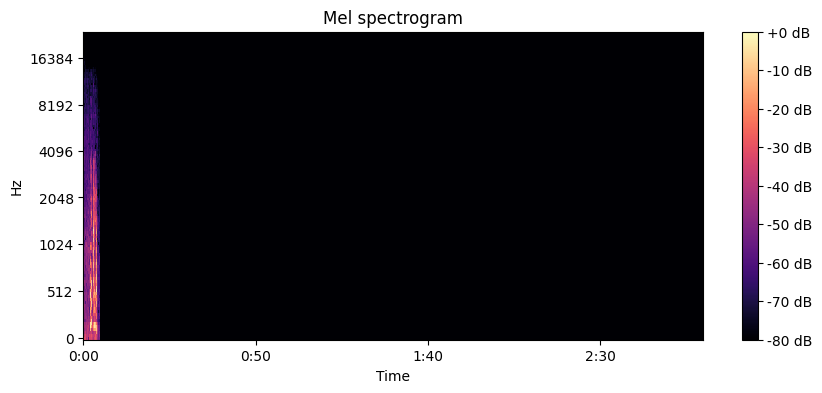

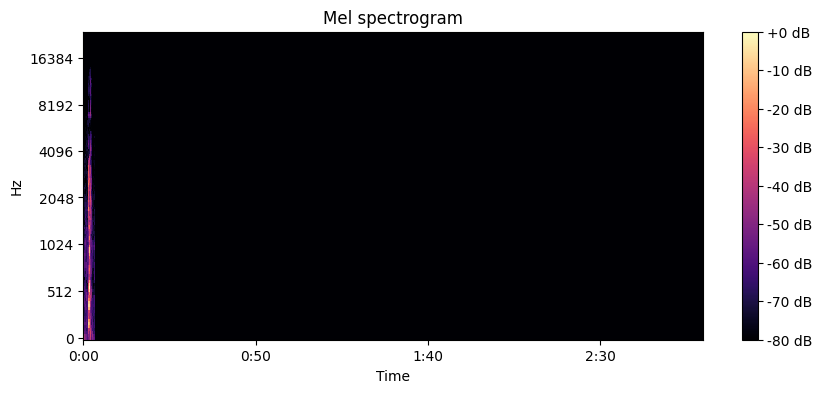

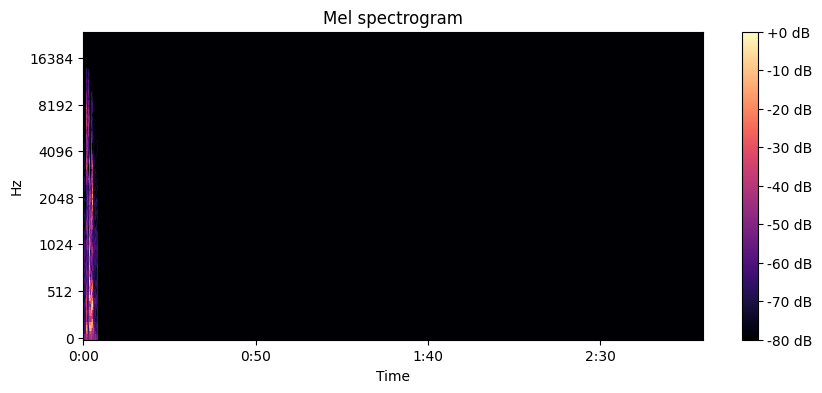

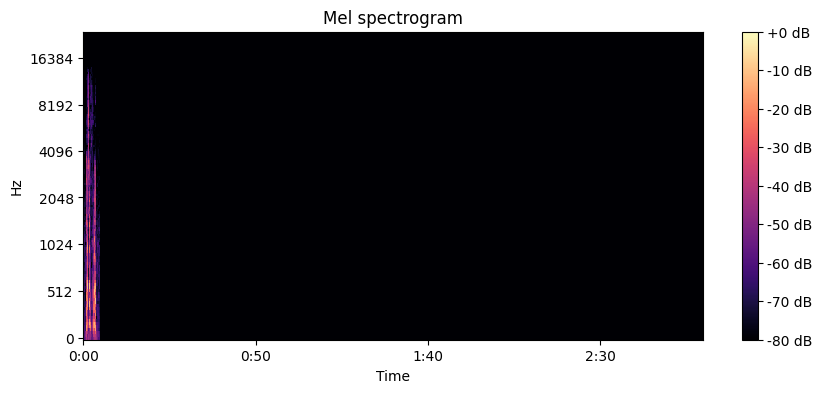

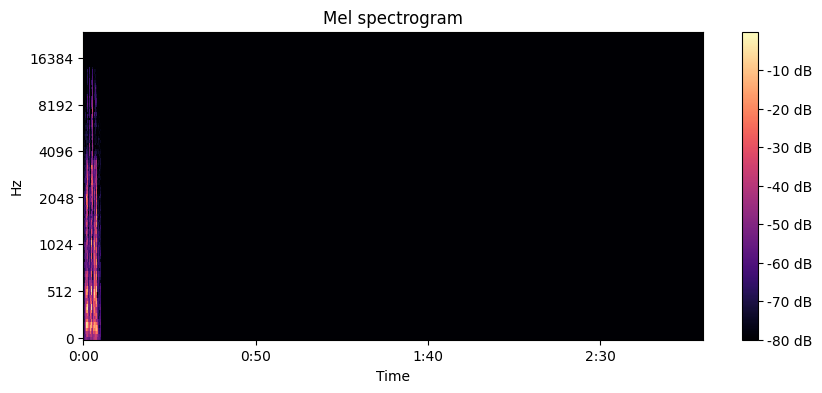

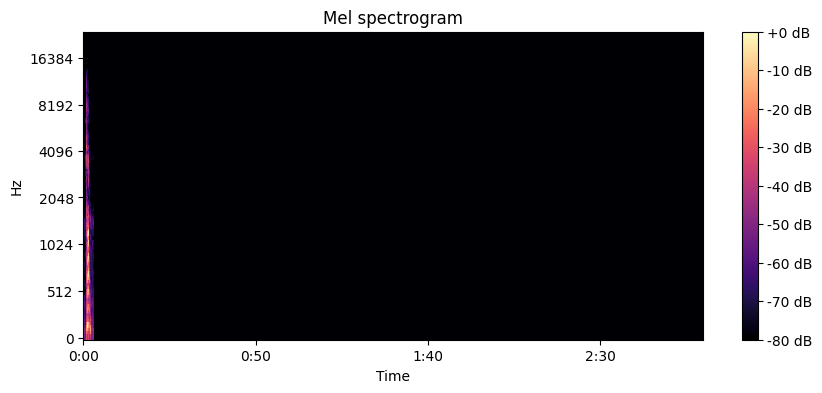

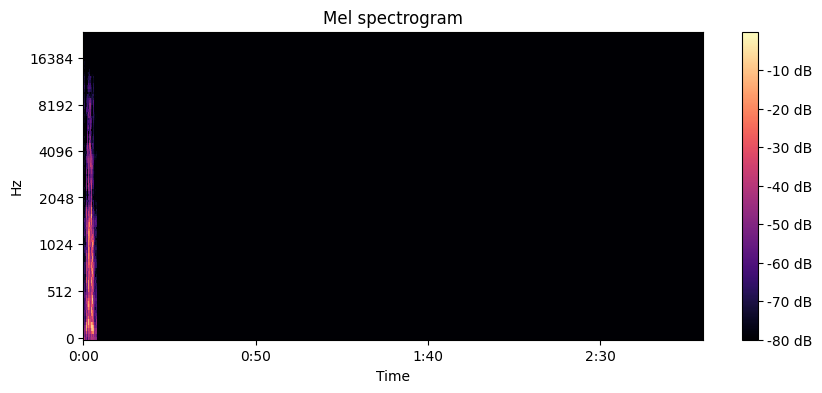

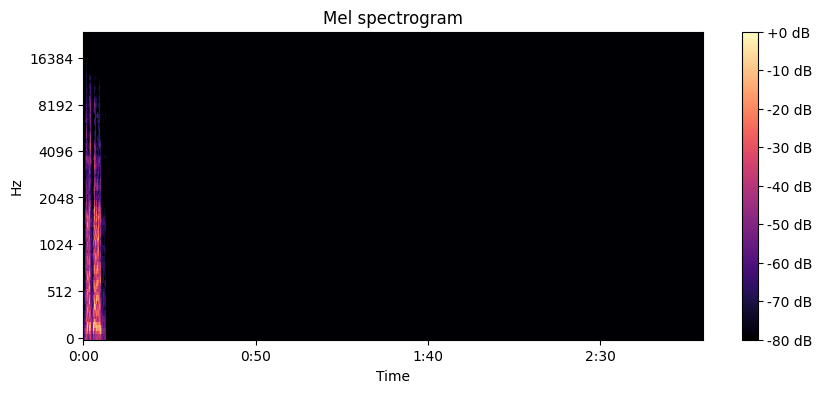

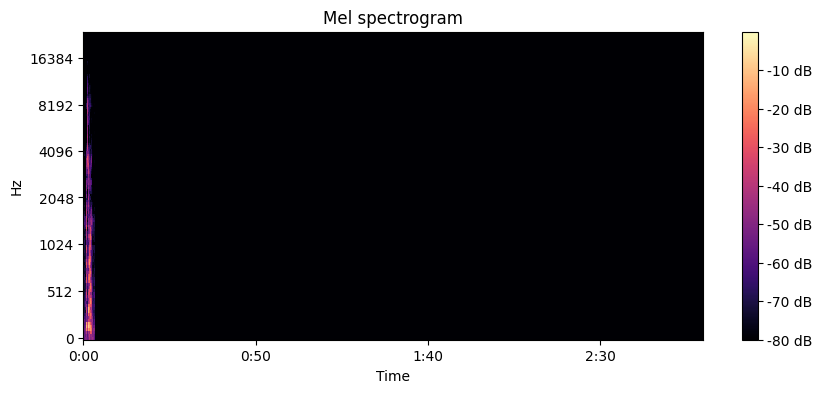

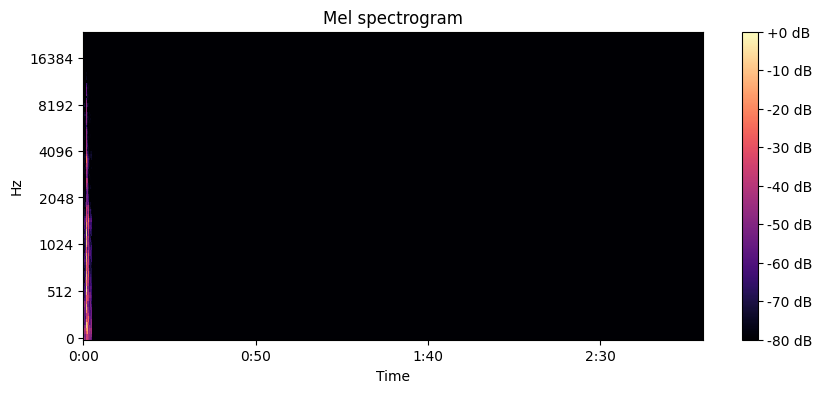

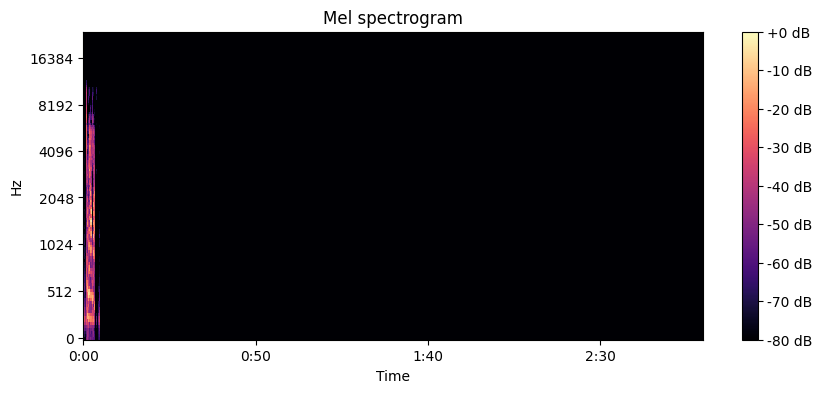

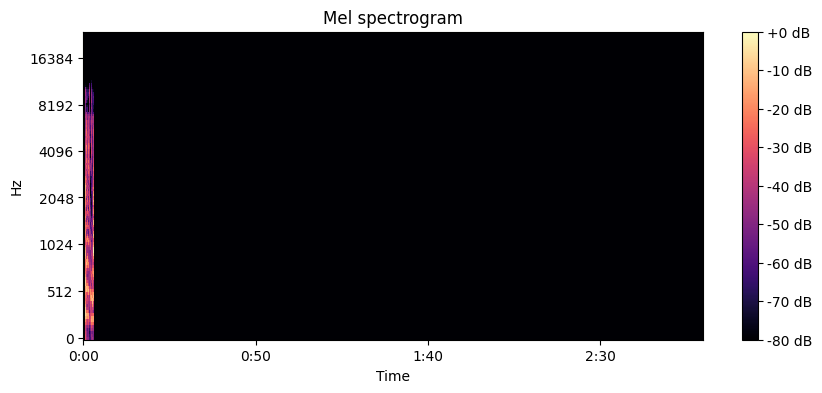

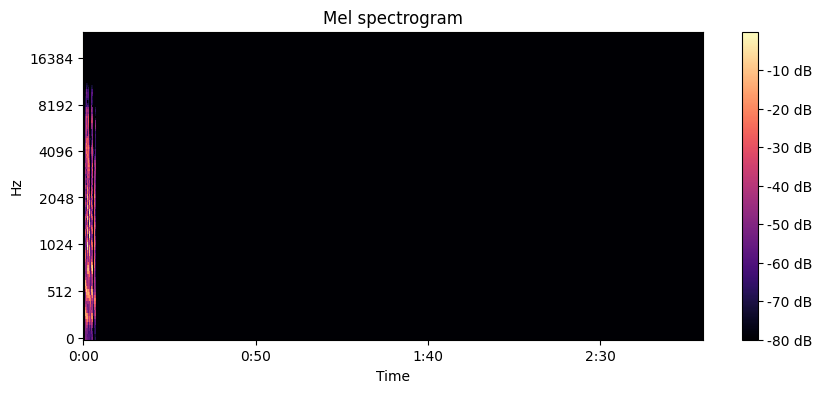

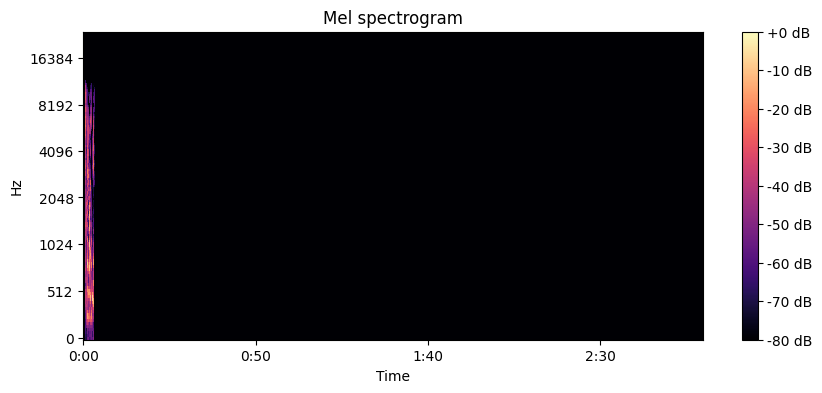

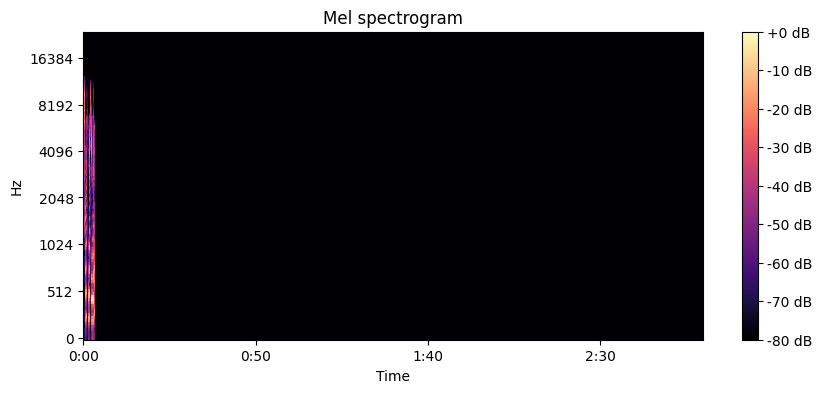

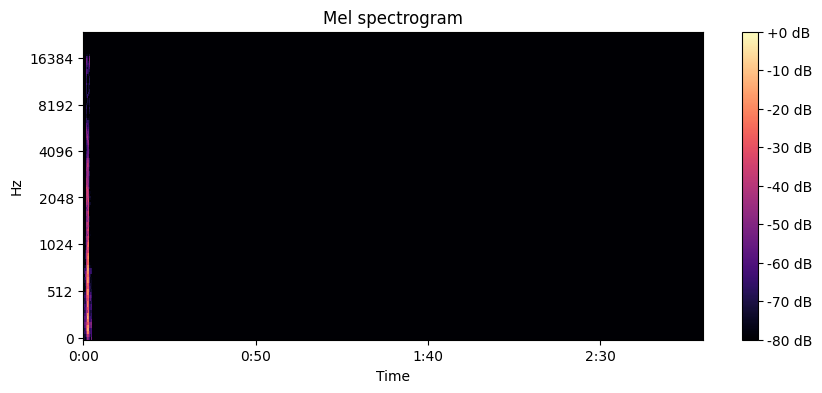

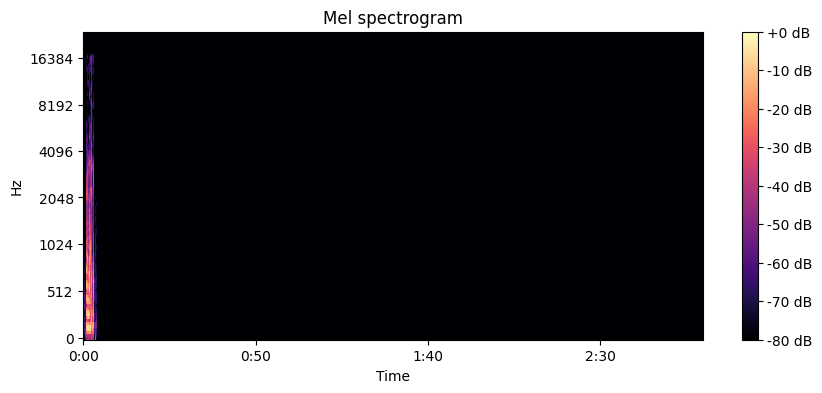

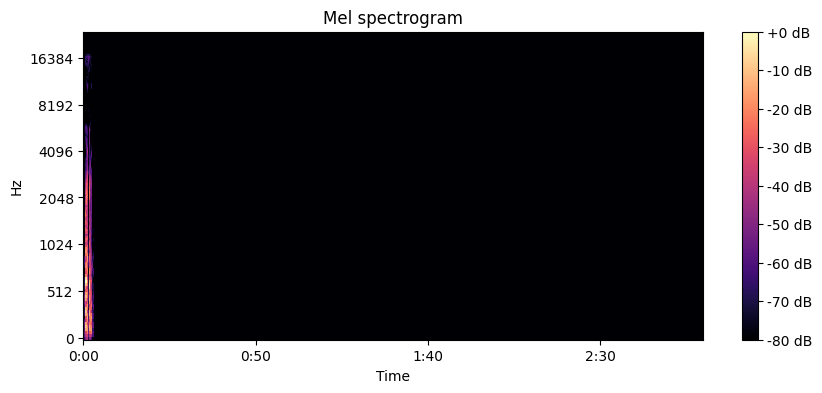

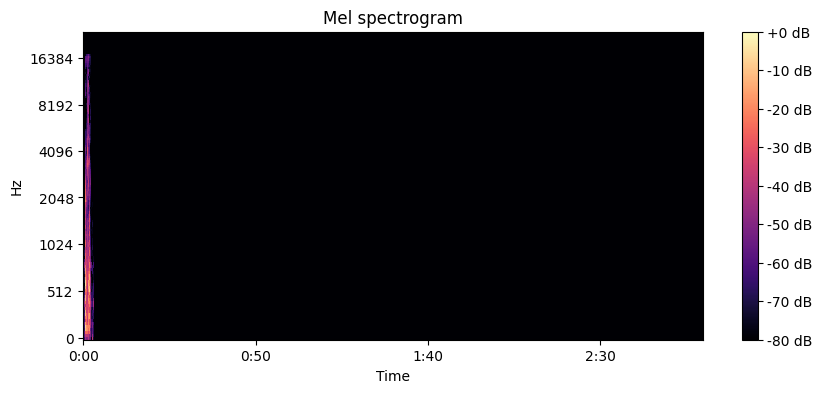

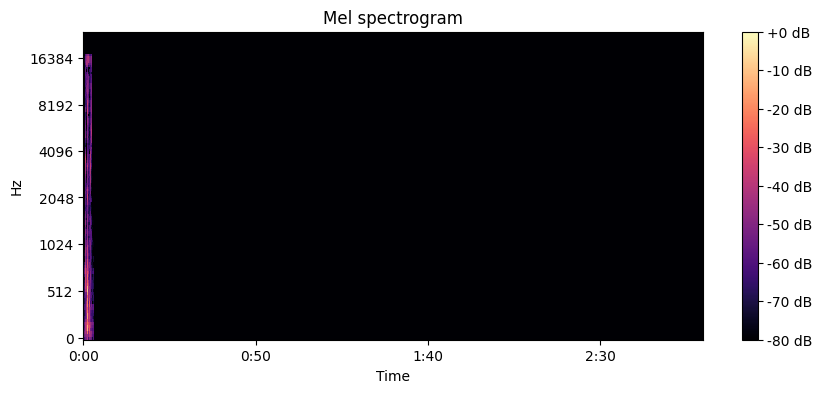

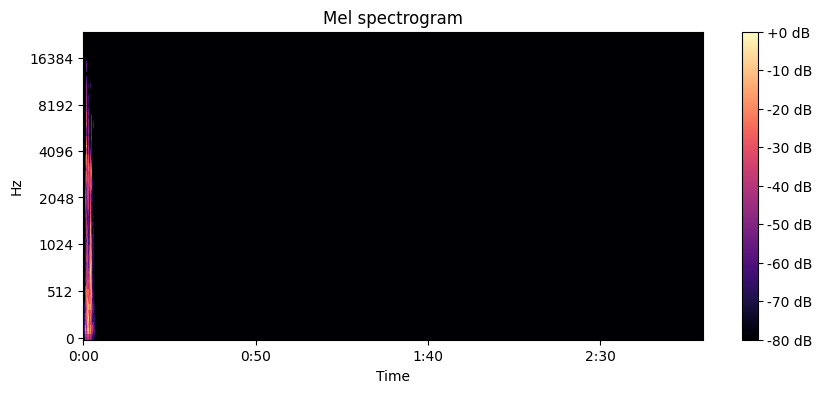

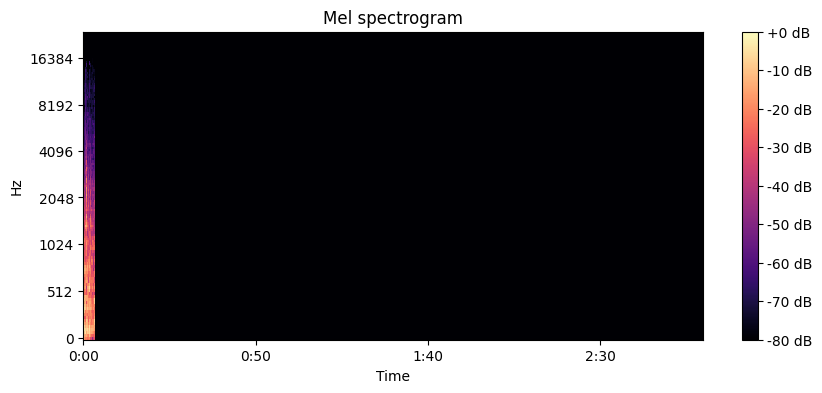

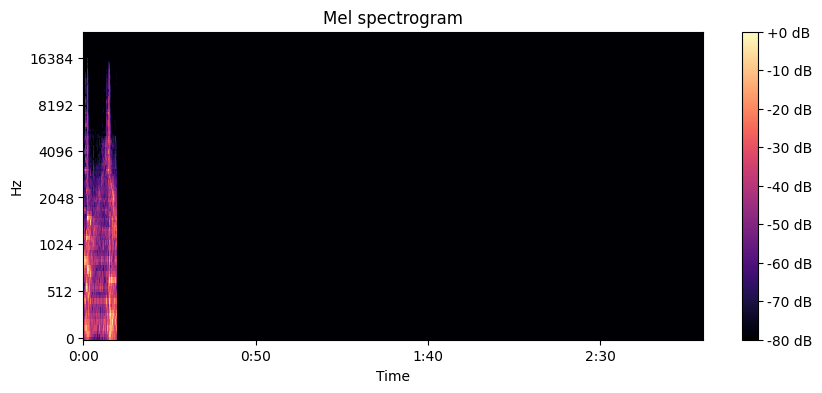

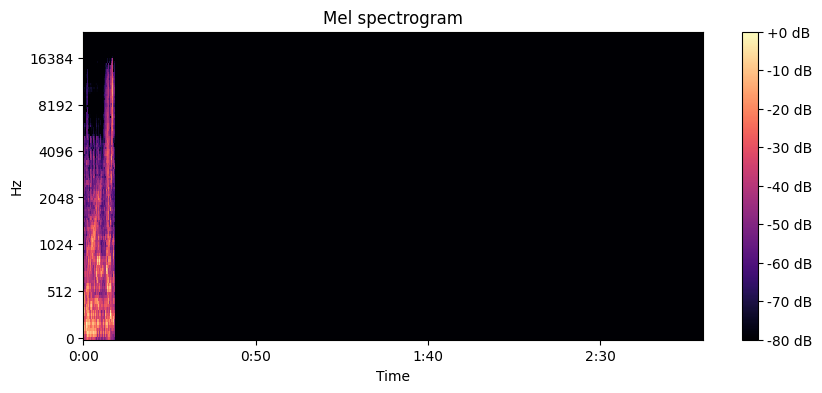

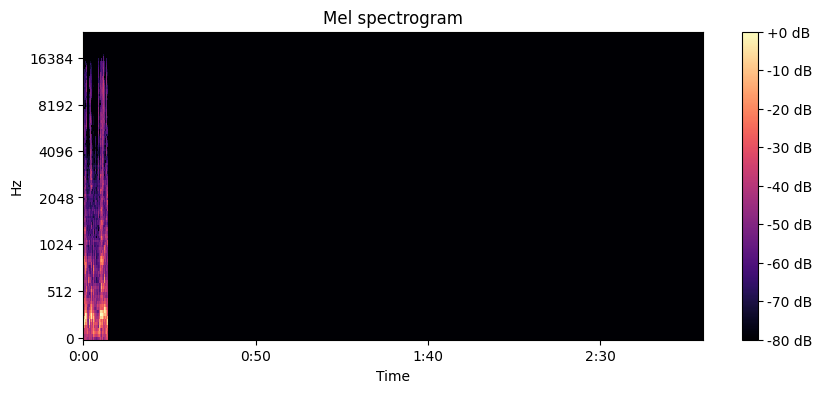

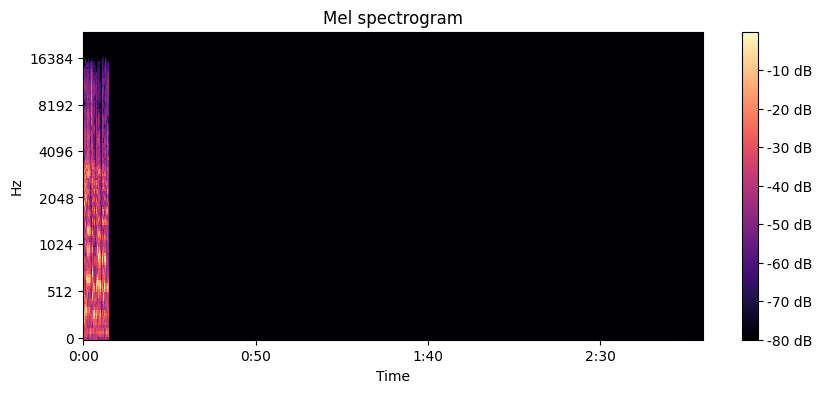

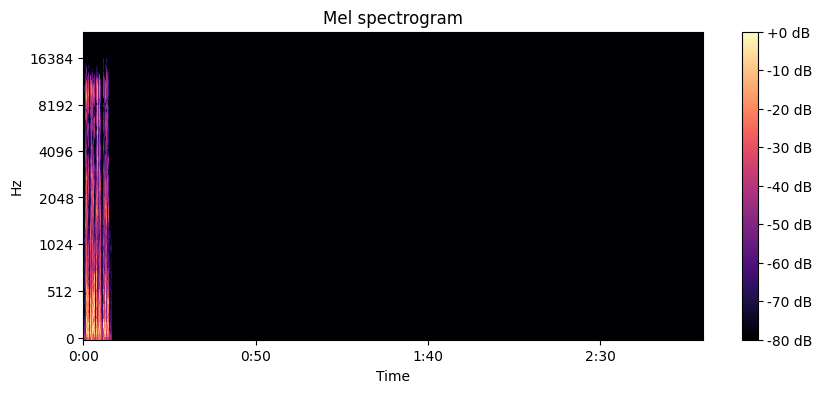

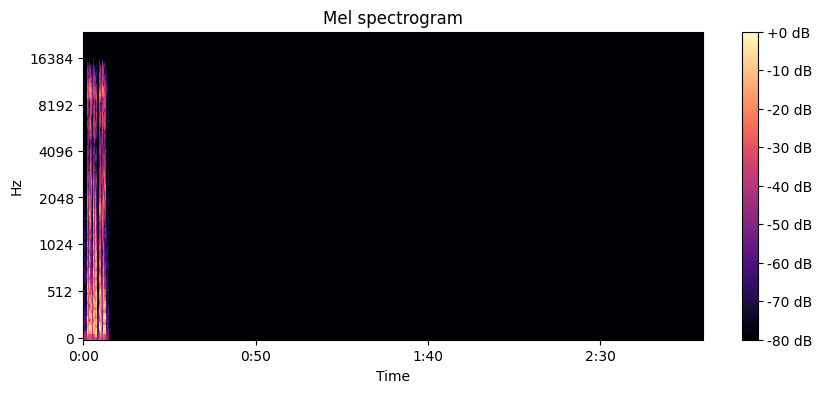

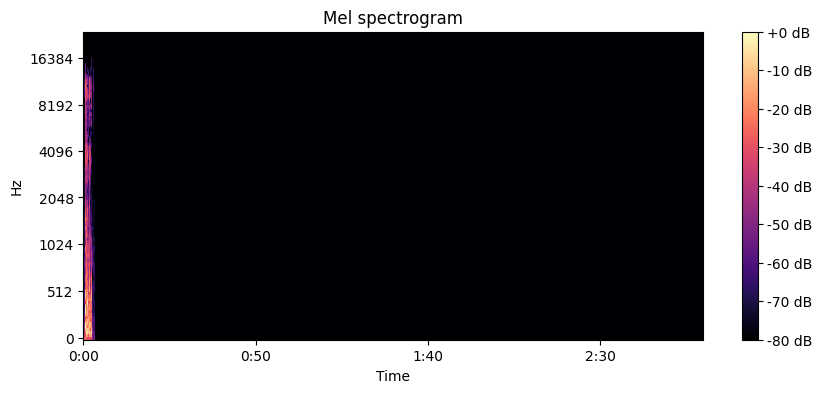

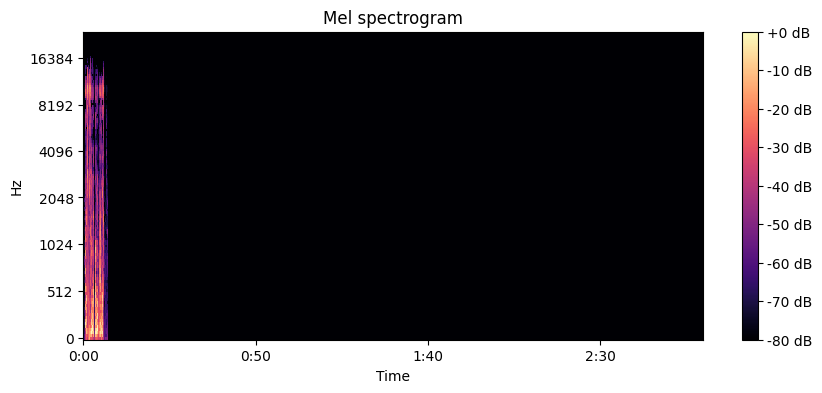

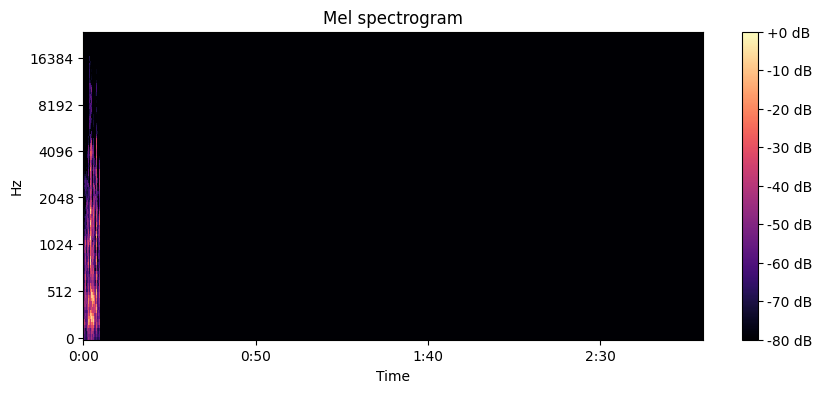

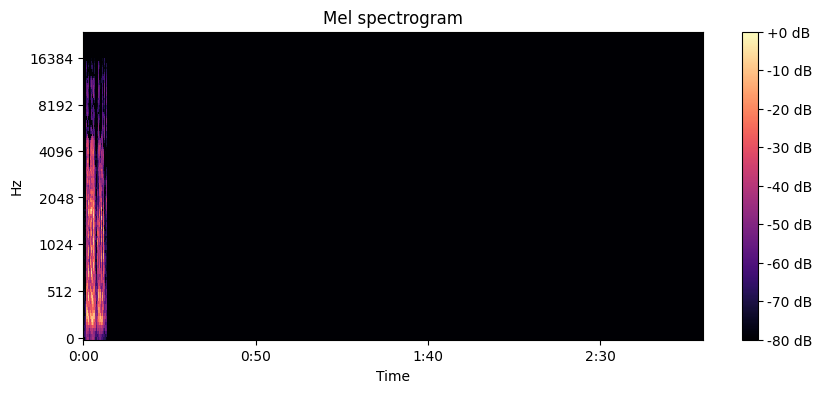

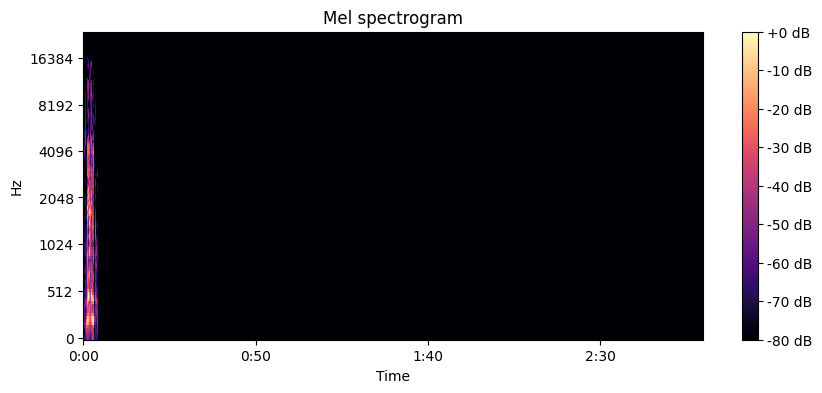

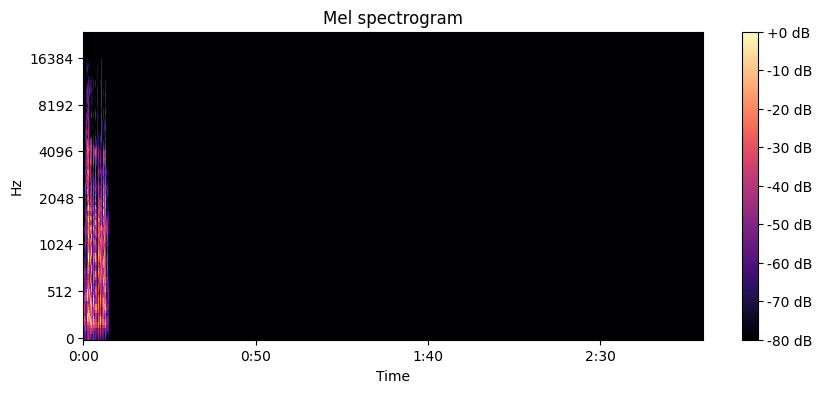

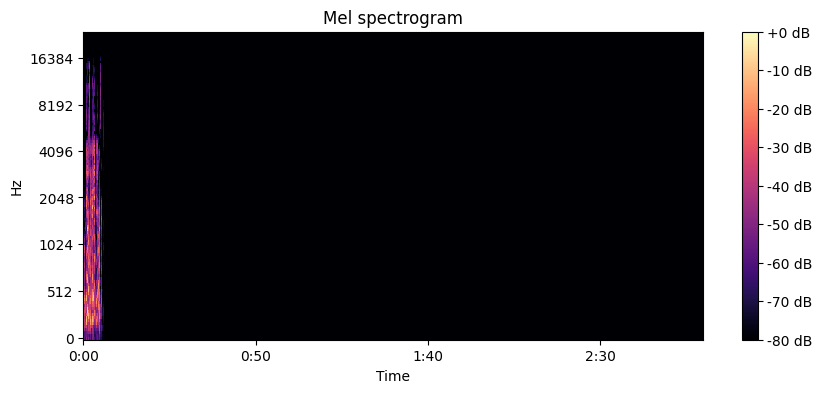

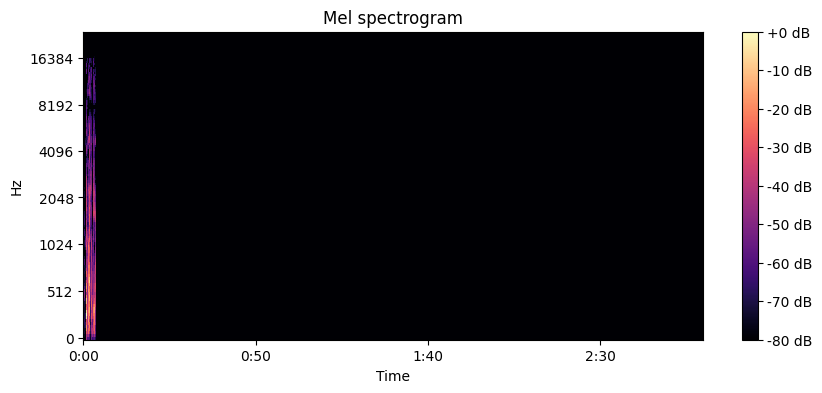

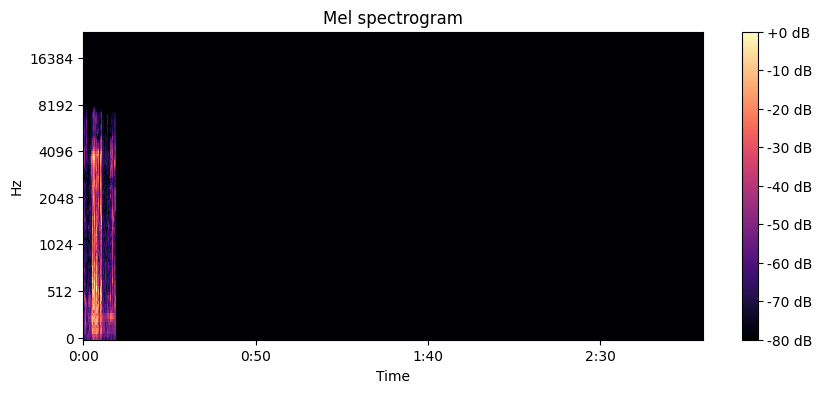

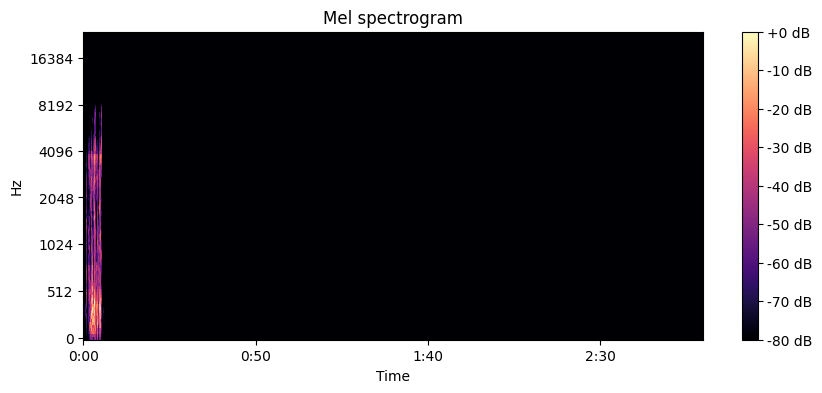

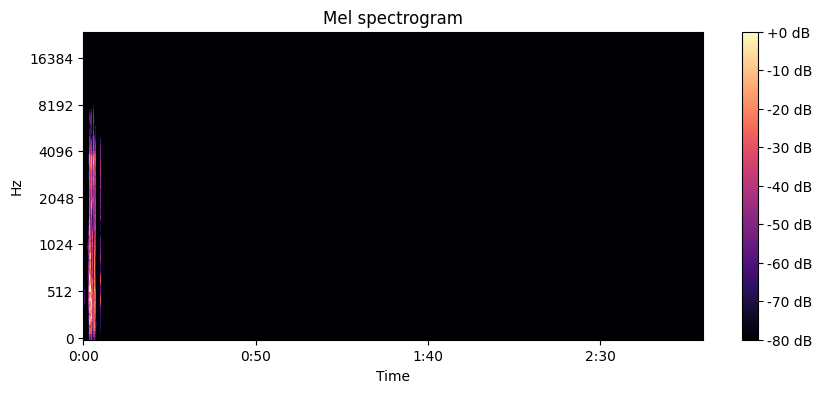

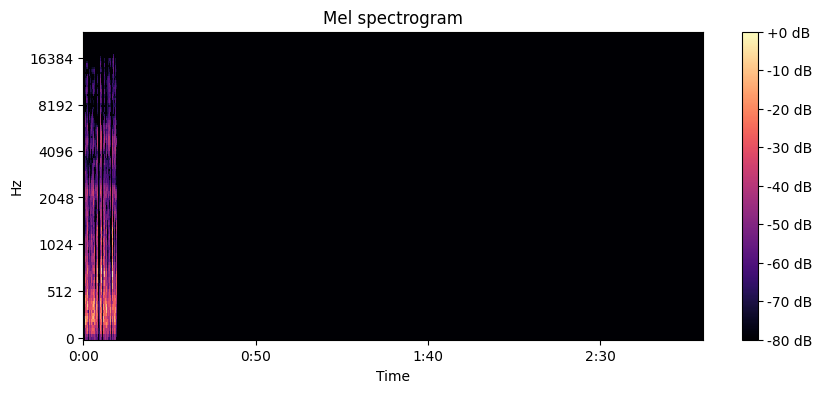

In [18]:

specs = compute_mel_spectograms(X_all, sampling_rate)
visualize_mel_spectograms(specs, sampling_rate)